# Prediksi Ketidakpatuhan Pasien (Versi Sederhana)

Notebook ini merangkum ulang alur kerja agar lebih sederhana dan mudah dipahami.

## Ringkasan Pipeline Baseline
1. Data loading
2. EDA & analisis imbalance
3. Preprocessing
4. Stratified 5-Fold CV
5. Train Logistic Regression
6. Train Decision Tree
7. Evaluate metrics
8. Analyze confusion matrix
9. ROC & PR curve
10. Interpretasi hasil

## STEP 1 - Baseline Experiment (Tanpa Penanganan Imbalance)


### Tujuan
- Mengukur performa asli model pada data tidak seimbang.
- Mengidentifikasi bias terhadap kelas mayoritas.
- Menjadi acuan peningkatan performa pada tahap imbalance learning.


### 1.1 Data Understanding and Initial Check
**1.1.1 Identifikasi Struktur Data**
- Jumlah sampel (N) dan jumlah fitur (p).
- Tipe fitur (numerik dan kategorikal).
- Target variable biner: patuh vs tidak patuh.
- Pastikan encoding target: 0 = Patuh (mayoritas), 1 = Tidak Patuh (minoritas).


**1.1.2 Analisis Distribusi Kelas**
- Hitung jumlah masing-masing kelas dan persentasenya.
- Hitung Imbalance Ratio (IR): $$IR = \frac{Jumlah\,Mayoritas}{Jumlah\,Minoritas}$$
- Laporkan dalam tabel dan bar chart distribusi kelas.
- Interpretasi contoh: dataset menunjukkan ketidakseimbangan kelas dengan rasio 5.67:1.


### 1.2 Data Preprocessing
Catatan: cleaning dilakukan sebelum split; encoding dan scaling final sebaiknya di pipeline.


**2.1 Missing Value Handling**
- Numerik: mean atau median.
- Kategorikal: modus.
- Laporkan jumlah missing sebelum dan sesudah imputasi.


**2.2 Encoding**
- One-hot encoding untuk fitur kategorikal.
- Label encoding dapat dipakai untuk model boosting tertentu bila diperlukan.


**2.3 Feature Scaling**
- Decision Tree dan boosting tidak wajib scaling.
- StandardScaler boleh dipakai agar konsisten lintas model.


### 1.3 Train-Test Split
- Gunakan Stratified 5-Fold Cross Validation agar proporsi kelas tetap konsisten.
- Catat rata-rata metrik dan standar deviasi pada setiap model.


### 1.4 Training Baseline Model
Model baseline dilatih tanpa penanganan imbalance:
- Tanpa SMOTE.
- Tanpa class_weight.
- Tanpa threshold tuning.
- Tanpa scale_pos_weight.


Model yang digunakan:
- Decision Tree
- XGBoost
- LightGBM
- CatBoost


Gunakan hyperparameter default atau tuning minimal (grid kecil).


### 1.5 Evaluasi Baseline
Metrik per fold:
- AUC
- Accuracy
- Sensitivity (Recall kelas minoritas)
- Specificity
- Precision
- F1-score


**5.1 Confusion Matrix**
- Hitung rata-rata confusion matrix per model.
- Sensitivity: $$\frac{TP}{TP + FN}$$
- Specificity: $$\frac{TN}{TN + FP}$$


**5.2 ROC Curve**
- Plot ROC untuk setiap model.
- Bandingkan AUC dan cek apakah sensitivity rendah meski AUC tinggi.


### 1.6 Analisis Hasil Baseline
Pola umum pada data imbalanced:
- Accuracy tinggi.
- AUC cukup baik.
- Sensitivity rendah.
- Model cenderung memprediksi kelas mayoritas.


Contoh narasi analisis:
"Meskipun model menunjukkan accuracy dan AUC yang relatif tinggi, sensitivity terhadap kelas tidak patuh masih rendah, menunjukkan bias terhadap kelas mayoritas. Hal ini menjadi justifikasi untuk masuk ke tahap imbalance learning."


### Output yang Harus Ada di Tesis
- Tabel distribusi kelas.
- Tabel performa baseline semua model.
- Grafik ROC.
- Confusion matrix.
- Analisis bias kelas minoritas.

In [1]:
# Import library inti
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,
 )

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Set random seed untuk reproducibility
np.random.seed(42)

In [2]:
# Memuat data
df = pd.read_csv("Dataset-Imbalance/medication_adherence.csv")
print("Jumlah data:", df.shape)
df.head()

Jumlah data: (2800, 24)


,patient_id,age,gender,chronic_condition,medication_type,dosage,comorbidities,BMI,event_id,timestamp,...,blood_pressure,blood_glucose,activity_level,sleep_hours,stress_level,reminder_sent,reminder_response_time,social_support,location,future_non_adherence
0,P0103,45,M,diabetes,Metformin,50,0,24.8,E00000,2025-05-22 02:46:32,...,139/81,170.2,8030,5.2,3,1,15.0,0,work,0
1,P0436,79,M,hypertension,Metformin,500,0,25.2,E00001,2025-03-02 22:26:25,...,123/82,80.1,5338,8.8,2,1,94.0,0,home,0
2,P0861,71,F,diabetes,Salbutamol,20,3,28.6,E00002,2025-09-13 02:37:54,...,138/80,110.1,9021,5.6,4,1,86.0,2,hospital,0
3,P0271,89,M,hypertension,Atorvastatin,10,0,22.9,E00003,2025-01-26 03:54:55,...,122/84,157.2,4930,4.8,4,1,100.0,4,hospital,0
4,P0107,84,F,diabetes,Amlodipine,10,3,34.5,E00004,2025-02-20 03:28:37,...,125/79,147.3,5960,7.6,3,0,NaN,2,hospital,0


## EDA & Analisis Imbalance
- Cek distribusi target dan missing value sederhana.

,count,percent
future_non_adherence,,
0,2102,0.7507
1,698,0.2493


Imbalance Ratio (IR): 3.01:1


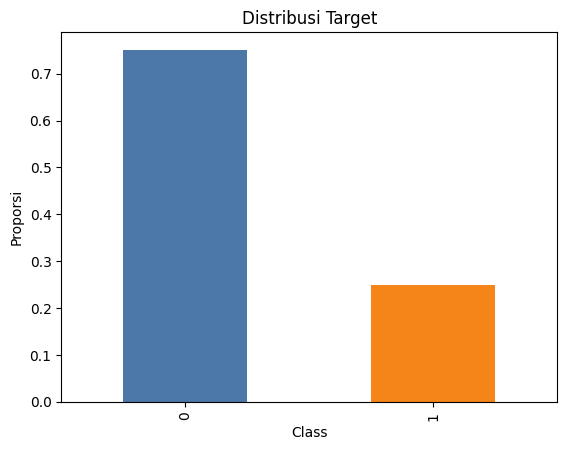

missed_reason             2393
reminder_response_time     834
dtype: int64

In [3]:
# Distribusi target (imbalanced check)
target_counts = df["future_non_adherence"].value_counts().sort_index()
dist_table = pd.DataFrame({
    "count": target_counts,
    "percent": (target_counts / target_counts.sum()).round(4),
})
display(dist_table)

ir = target_counts.loc[0] / target_counts.loc[1]
print(f"Imbalance Ratio (IR): {ir:.2f}:1")

(target_counts / target_counts.sum()).plot(kind="bar", color=["#4C78A8", "#F58518"])
plt.title("Distribusi Target")
plt.xlabel("Class")
plt.ylabel("Proporsi")
plt.show()

# Ringkas missing value
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0].head(10))

In [4]:
# Fitur target dan kolom yang tidak dipakai
TARGET = "future_non_adherence"
DROP_COLS = ["patient_id", "event_id"]

# Rekayasa fitur sederhana
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek

# Memisahkan blood_pressure
df[["bp_systolic", "bp_diastolic"]] = (
    df["blood_pressure"].str.split("/", expand=True).astype(float)
)

# Menangani missing value sederhana
df["reminder_response_time"] = df["reminder_response_time"].fillna(-1)

In [5]:
# Memisahkan fitur (X) dan target (y)
X = df.drop(columns=DROP_COLS + [TARGET, "timestamp", "blood_pressure"])
y = df[TARGET]

# Definisikan fitur kategorikal dan numerikal
categorical_features = ["gender", "chronic_condition", "medication_type", "location"]
numerical_features = [
    "age", "dosage", "BMI", "activity_level", "sleep_hours", "stress_level",
    "blood_glucose", "bp_systolic", "bp_diastolic", "reminder_sent",
    "reminder_response_time", "social_support", "hour", "dayofweek"
]

In [6]:
# Ringkasan struktur data
N = df.shape[0]
p = X.shape[1]
print("Jumlah sampel (N):", N)
print("Jumlah fitur (p):", p)
print("Fitur numerik:", len(numerical_features))
print("Fitur kategorikal:", len(categorical_features))

Jumlah sampel (N): 2800
Jumlah fitur (p): 23
Fitur numerik: 14
Fitur kategorikal: 4


In [7]:
# Preprocessing: OneHot untuk kategorikal, numerik diteruskan
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

In [8]:
# --- STEP 2: DEFINISI TUJUAN BASELINE ---
# BASELINE = model dilatih tanpa teknik imbalance:
# - Tanpa resampling (SMOTE, ROS)
# - Tanpa class weighting
# - Tanpa threshold tuning (default = 0.5)
print("="*60)
print("BASELINE EXPERIMENT - TANPA PENANGANAN IMBALANCE")
print("="*60)

# Model baseline (default parameters, no imbalance handling)
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric="logloss",
        verbose=0,
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=-1,
        random_state=42,
        verbose=-1,
    ),
}

print(f"Model yang akan dievaluasi: {list(models.keys())}")
print(f"Total model: {len(models)}")
print(f"Threshold prediksi: 0.5 (default)")
print(f"Penanganan imbalance: TIDAK ADA")
print("="*60)

BASELINE EXPERIMENT - TANPA PENANGANAN IMBALANCE
Model yang akan dievaluasi: ['DecisionTree', 'XGBoost', 'LightGBM']
Total model: 3
Threshold prediksi: 0.5 (default)
Penanganan imbalance: TIDAK ADA


In [9]:
# --- STEP 3 & 4: STRATIFIED 10-FOLD CV + TRAINING BASELINE ---
print("\n" + "="*60)
print("STEP 3-4: STRATIFIED 10-FOLD CROSS VALIDATION")
print("="*60)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print(f"Setup: {skf.get_n_splits()} fold, shuffle=True, random_state=42")

# Dictionary untuk menyimpan hasil CV per model
baseline_results = {}  # {model_name: {fold_i: {accuracy, sensitivity, specificity, precision, f1, auc}}}
all_y_true = {}  # Untuk ROC curve
all_y_proba = {}  # Untuk ROC curve

for model_name, model in models.items():
    baseline_results[model_name] = []
    all_y_true[model_name] = []
    all_y_proba[model_name] = []
    print(f"\n--- Training {model_name} ---")

    fold_num = 0
    for train_idx, val_idx in skf.split(X, y):
        fold_num += 1
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Build pipeline dengan preprocessing
        pipeline = Pipeline([
            ("preprocess", preprocessor),
            ("model", model),
        ])

        # Training (tanpa class_weight, scale_pos_weight, atau teknik imbalance lainnya)
        pipeline.fit(X_train, y_train)

        # Prediksi pada validation fold
        y_proba = pipeline.predict_proba(X_val)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)  # Threshold = 0.5

        # Hitung confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Hitung metrik evaluasi (STEP 4.5)
        accuracy = accuracy_score(y_val, y_pred)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Recall minoritas
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        f1 = f1_score(y_val, y_pred, zero_division=0)
        auc = roc_auc_score(y_val, y_proba)

        # Simpan hasil fold (STEP 4.6)
        baseline_results[model_name].append({
            "Fold": fold_num,
            "Accuracy": accuracy,
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "Precision": precision,
            "F1-Score": f1,
            "AUC": auc,
        })

        # Simpan data untuk ROC curve
        all_y_true[model_name].extend(y_val.tolist())
        all_y_proba[model_name].extend(y_proba.tolist())

        if fold_num <= 3 or fold_num == 10:  # Tampilkan fold 1-3 dan 10
            print(f"  Fold {fold_num}: Acc={accuracy:.4f}, Sens={sensitivity:.4f}, AUC={auc:.4f}")
    print(f"  ...{model_name} selesai semua fold.")

print("\nSemua model selesai dilatih.")
print("="*60)


STEP 3-4: STRATIFIED 10-FOLD CROSS VALIDATION
Setup: 10 fold, shuffle=True, random_state=42

--- Training DecisionTree ---
  Fold 1: Acc=0.5893, Sens=0.1884, AUC=0.4544
  Fold 2: Acc=0.6286, Sens=0.3188, AUC=0.5243
  Fold 3: Acc=0.5643, Sens=0.1857, AUC=0.4381
  Fold 10: Acc=0.5750, Sens=0.2429, AUC=0.4643
  ...DecisionTree selesai semua fold.

--- Training XGBoost ---


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1: Acc=0.7214, Sens=0.0290, AUC=0.4879


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2: Acc=0.7143, Sens=0.0580, AUC=0.5004


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3: Acc=0.7321, Sens=0.0143, AUC=0.5663


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:33] WARNING: /Users/runner/work/xgboos

  Fold 10: Acc=0.7357, Sens=0.0429, AUC=0.4628
  ...XGBoost selesai semua fold.

--- Training LightGBM ---


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 1: Acc=0.7036, Sens=0.0435, AUC=0.5420


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 2: Acc=0.7179, Sens=0.0435, AUC=0.4522


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 3: Acc=0.7250, Sens=0.0143, AUC=0.5549


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/

  Fold 10: Acc=0.7286, Sens=0.0857, AUC=0.5341
  ...LightGBM selesai semua fold.

Semua model selesai dilatih.


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [10]:
# --- STEP 5: AGREGASI HASIL (Mean & Std) ---
print("\n" + "="*60)
print("STEP 5: AGREGASI HASIL 10-FOLD CV")
print("="*60)

# Buat tabel ringkasan untuk setiap model
summary_results = []

for model_name, fold_results in baseline_results.items():
    fold_df = pd.DataFrame(fold_results)
    summary = {
        "Model": model_name,
        "Accuracy_mean": fold_df["Accuracy"].mean(),
        "Accuracy_std": fold_df["Accuracy"].std(),
        "Sensitivity_mean": fold_df["Sensitivity"].mean(),
        "Sensitivity_std": fold_df["Sensitivity"].std(),
        "Specificity_mean": fold_df["Specificity"].mean(),
        "Specificity_std": fold_df["Specificity"].std(),
        "Precision_mean": fold_df["Precision"].mean(),
        "Precision_std": fold_df["Precision"].std(),
        "F1-Score_mean": fold_df["F1-Score"].mean(),
        "F1-Score_std": fold_df["F1-Score"].std(),
        "AUC_mean": fold_df["AUC"].mean(),
        "AUC_std": fold_df["AUC"].std(),
    }
    summary_results.append(summary)

baseline_summary_df = pd.DataFrame(summary_results)
print("\nTabel Ringkasan Baseline (10-Fold CV):")
print(baseline_summary_df.to_string(index=False))

# Simpan ke CSV
baseline_summary_df.to_csv("baseline_summary.csv", index=False)
print("\nTabel tersimpan di: baseline_summary.csv")


STEP 5: AGREGASI HASIL 10-FOLD CV

Tabel Ringkasan Baseline (10-Fold CV):
       Model  Accuracy_mean  Accuracy_std  Sensitivity_mean  Sensitivity_std  Specificity_mean  Specificity_std  Precision_mean  Precision_std  F1-Score_mean  F1-Score_std  AUC_mean  AUC_std
DecisionTree       0.602143      0.025096          0.272153         0.050790          0.711690         0.023402        0.238563       0.042829       0.254052      0.045869  0.491922 0.031501
     XGBoost       0.728571      0.010911          0.055839         0.035253          0.951963         0.016657        0.256969       0.138565       0.090752      0.055422  0.511996 0.045230
    LightGBM       0.728214      0.014527          0.051553         0.032401          0.952925         0.018332        0.256549       0.165584       0.085062      0.053119  0.514947 0.042911

Tabel tersimpan di: baseline_summary.csv



STEP 7: KOMPARASI BASELINE - TABEL PERFORMA

Performa Baseline Model (Rata-rata 10-Fold):
       Model  Accuracy  Sensitivity  Specificity  Precision  F1-Score    AUC
DecisionTree    0.6021       0.2722       0.7117     0.2386    0.2541 0.4919
     XGBoost    0.7286       0.0558       0.9520     0.2570    0.0908 0.5120
    LightGBM    0.7282       0.0516       0.9529     0.2565    0.0851 0.5149


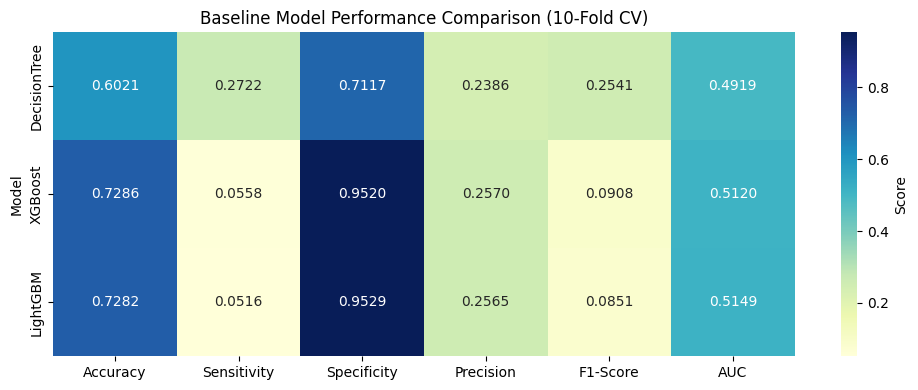

In [11]:
# --- STEP 7: KOMPARASI BASELINE & VISUALISASI ---
print("\n" + "="*60)
print("STEP 7: KOMPARASI BASELINE - TABEL PERFORMA")
print("="*60)

# Tabel format untuk tesis (format yang lebih rapi)
comparison_table = baseline_summary_df[["Model", "Accuracy_mean", "Sensitivity_mean", "Specificity_mean", "Precision_mean", "F1-Score_mean", "AUC_mean"]].copy()
comparison_table.columns = ["Model", "Accuracy", "Sensitivity", "Specificity", "Precision", "F1-Score", "AUC"]

# Round ke 4 decimal
for col in comparison_table.columns[1:]:
    comparison_table[col] = comparison_table[col].round(4)

print("\nPerforma Baseline Model (Rata-rata 10-Fold):")
print(comparison_table.to_string(index=False))

# Visualisasi heatmap perbandingan metrik
metrics_to_plot = ["Accuracy_mean", "Sensitivity_mean", "Specificity_mean", "Precision_mean", "F1-Score_mean", "AUC_mean"]
plot_data = baseline_summary_df[["Model"] + metrics_to_plot].set_index("Model")
plot_data.columns = ["Accuracy", "Sensitivity", "Specificity", "Precision", "F1-Score", "AUC"]

plt.figure(figsize=(10, 4))
sns.heatmap(plot_data, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={"label": "Score"})
plt.title("Baseline Model Performance Comparison (10-Fold CV)")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


ROC CURVE - Baseline Models


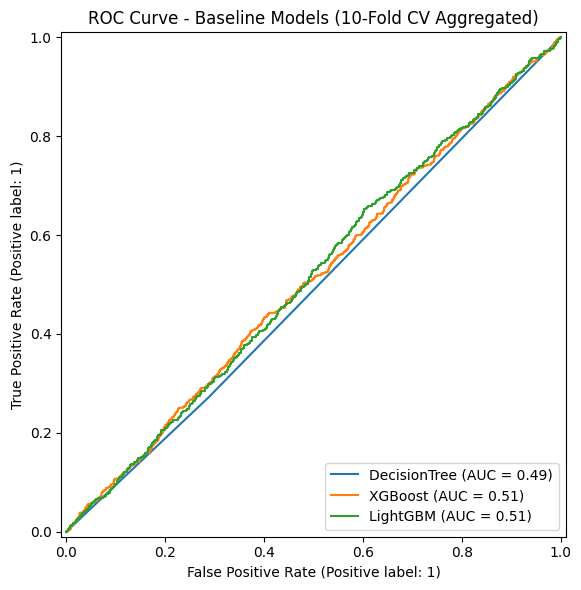

In [12]:
# --- ROC CURVE BASELINE ---
print("\n" + "="*60)
print("ROC CURVE - Baseline Models")
print("="*60)

plt.figure(figsize=(8, 6))
for model_name in models.keys():
    y_true_all = np.array(all_y_true[model_name])
    y_proba_all = np.array(all_y_proba[model_name])
    RocCurveDisplay.from_predictions(
        y_true_all,
        y_proba_all,
        name=model_name,
        ax=plt.gca(),
    )

plt.title("ROC Curve - Baseline Models (10-Fold CV Aggregated)")
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()

In [13]:
# --- STEP 8: ANALISIS HASIL BASELINE ---
print("\n" + "="*60)
print("STEP 8: ANALISIS HASIL BASELINE")
print("="*60)

# Identifikasi masalah bias kelas minoritas
print("\n[ANALISIS BIAS KELAS MINORITAS]")
for idx, row in baseline_summary_df.iterrows():
    model_name = row["Model"]
    acc = row["Accuracy_mean"]
    sens = row["Sensitivity_mean"]
    spec = row["Specificity_mean"]
    auc = row["AUC_mean"]
    f1 = row["F1-Score_mean"]

    print(f"\n{model_name}:", "-" * 50)
    print(f"  Accuracy: {acc:.4f}, AUC: {auc:.4f}", end="")

    # Check markers of class imbalance bias
    if acc > 0.75 and sens < 0.35:
        print("  ⚠ TINGGI ACCURACY, SENSITIVITY RENDAH")
    elif acc > 0.80 and auc > 0.60 and sens < 0.30:
        print("  ⚠ BIAS MAYORITAS KUAT")
    else:
        print()

    print(f"  Sensitivity (Recall minoritas): {sens:.4f} ← PENTING (harus ~0.4+)")
    print(f"  Specificity: {spec:.4f}")
    print(f"  F1-Score: {f1:.4f}")

print("\n[INTERPRETASI]")
print("Jika Sensitivity < 0.35 padahal Accuracy > 0.75, maka:")
print("  → Model bias terhadap kelas mayoritas (patuh).")
print("  → Banyak false negative (non-adherent yang terlewat).")
print("  → Ini JUSTIFIKASI untuk menggunakan teknik imbalance learning.")
print("="*60)


STEP 8: ANALISIS HASIL BASELINE

[ANALISIS BIAS KELAS MINORITAS]

DecisionTree: --------------------------------------------------
  Accuracy: 0.6021, AUC: 0.4919
  Sensitivity (Recall minoritas): 0.2722 ← PENTING (harus ~0.4+)
  Specificity: 0.7117
  F1-Score: 0.2541

XGBoost: --------------------------------------------------
  Accuracy: 0.7286, AUC: 0.5120
  Sensitivity (Recall minoritas): 0.0558 ← PENTING (harus ~0.4+)
  Specificity: 0.9520
  F1-Score: 0.0908

LightGBM: --------------------------------------------------
  Accuracy: 0.7282, AUC: 0.5149
  Sensitivity (Recall minoritas): 0.0516 ← PENTING (harus ~0.4+)
  Specificity: 0.9529
  F1-Score: 0.0851

[INTERPRETASI]
Jika Sensitivity < 0.35 padahal Accuracy > 0.75, maka:
  → Model bias terhadap kelas mayoritas (patuh).
  → Banyak false negative (non-adherent yang terlewat).
  → Ini JUSTIFIKASI untuk menggunakan teknik imbalance learning.


## STEP 2 - Eksperimen Resampling (Imbalance Learning)

Tujuan tahap ini:
- Meningkatkan sensitivity (recall minoritas).
- Meningkatkan F1-score.
- Mengurangi bias terhadap kelas mayoritas.
- Membandingkan dengan baseline.

Prinsip utama: resampling hanya dilakukan pada data training di setiap fold (validation tidak disentuh).

In [14]:
# --- STEP 2.1 - 2.5: RESAMPLING EXPERIMENTS (10-FOLD CV) ---
print("\n" + "="*60)
print("STEP 2: RESAMPLING EXPERIMENTS (IMBALANCE LEARNING)")
print("="*60)

# Teknik resampling
resamplers = {
    "ROS": RandomOverSampler(random_state=42),
    "RUS": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
}

# Pastikan model baseline tersedia (tanpa class_weight)
resampling_results = []
resampling_details = {}
all_y_true_res = {}
all_y_proba_res = {}

skf_res = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print(f"Setup: {skf_res.get_n_splits()} fold, shuffle=True, random_state=42")

for model_name, model in models.items():
    for res_name, resampler in resamplers.items():
        combo_key = f"{model_name}_{res_name}"
        fold_rows = []
        all_y_true_res[combo_key] = []
        all_y_proba_res[combo_key] = []
        print(f"\n--- {combo_key} ---")

        fold_num = 0
        for train_idx, val_idx in skf_res.split(X, y):
            fold_num += 1
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Resampling hanya pada data training di setiap fold
            pipeline = ImbPipeline([
                ("preprocess", preprocessor),
                ("resample", resampler),
                ("model", model),
            ])
            pipeline.fit(X_train, y_train)

            y_proba = pipeline.predict_proba(X_val)[:, 1]
            y_pred = (y_proba >= 0.5).astype(int)

            cm = confusion_matrix(y_val, y_pred)
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            f1 = f1_score(y_val, y_pred, zero_division=0)
            accuracy = accuracy_score(y_val, y_pred)
            auc = roc_auc_score(y_val, y_proba)

            fold_rows.append({
                "Fold": fold_num,
                "Accuracy": accuracy,
                "Sensitivity": sensitivity,
                "Specificity": specificity,
                "Precision": precision,
                "F1-Score": f1,
                "AUC": auc,
            })

            all_y_true_res[combo_key].extend(y_val.tolist())
            all_y_proba_res[combo_key].extend(y_proba.tolist())

            if fold_num <= 2 or fold_num == 10:
                print(f"  Fold {fold_num}: Acc={accuracy:.4f}, Sens={sensitivity:.4f}, AUC={auc:.4f}")

        fold_df = pd.DataFrame(fold_rows)
        resampling_details[combo_key] = fold_df

        resampling_results.append({
            "Model": model_name,
            "Resampling": res_name,
            "Accuracy_mean": fold_df["Accuracy"].mean(),
            "Accuracy_std": fold_df["Accuracy"].std(),
            "Sensitivity_mean": fold_df["Sensitivity"].mean(),
            "Sensitivity_std": fold_df["Sensitivity"].std(),
            "Specificity_mean": fold_df["Specificity"].mean(),
            "Specificity_std": fold_df["Specificity"].std(),
            "Precision_mean": fold_df["Precision"].mean(),
            "Precision_std": fold_df["Precision"].std(),
            "F1-Score_mean": fold_df["F1-Score"].mean(),
            "F1-Score_std": fold_df["F1-Score"].std(),
            "AUC_mean": fold_df["AUC"].mean(),
            "AUC_std": fold_df["AUC"].std(),
        })

resampling_summary_df = pd.DataFrame(resampling_results)
print("\nRingkasan Resampling (Mean ± Std):")
print(resampling_summary_df.to_string(index=False))

# Simpan ringkasan resampling
resampling_summary_df.to_csv("resampling_summary.csv", index=False)
print("\nRingkasan disimpan di: resampling_summary.csv")


STEP 2: RESAMPLING EXPERIMENTS (IMBALANCE LEARNING)
Setup: 10 fold, shuffle=True, random_state=42

--- DecisionTree_ROS ---
  Fold 1: Acc=0.5679, Sens=0.2319, AUC=0.4548
  Fold 2: Acc=0.5607, Sens=0.1594, AUC=0.4257
  Fold 10: Acc=0.5786, Sens=0.2000, AUC=0.4524

--- DecisionTree_RUS ---
  Fold 1: Acc=0.5143, Sens=0.5797, AUC=0.5363
  Fold 2: Acc=0.5214, Sens=0.4203, AUC=0.4874
  Fold 10: Acc=0.4929, Sens=0.4429, AUC=0.4762

--- DecisionTree_SMOTE ---
  Fold 1: Acc=0.6500, Sens=0.3333, AUC=0.5434
  Fold 2: Acc=0.5964, Sens=0.2899, AUC=0.4933
  Fold 10: Acc=0.5679, Sens=0.2286, AUC=0.4548

--- XGBoost_ROS ---


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1: Acc=0.7036, Sens=0.2174, AUC=0.5309


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2: Acc=0.6786, Sens=0.1304, AUC=0.5116


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:42] WARNING: /Users/runner/work/xgboos

  Fold 10: Acc=0.6929, Sens=0.1571, AUC=0.4784

--- XGBoost_RUS ---


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1: Acc=0.5143, Sens=0.4928, AUC=0.5031


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2: Acc=0.5036, Sens=0.5507, AUC=0.5180


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:44] WARNING: /Users/runner/work/xgboos

  Fold 10: Acc=0.5286, Sens=0.4857, AUC=0.5150

--- XGBoost_SMOTE ---


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1: Acc=0.7250, Sens=0.0435, AUC=0.5496


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2: Acc=0.7286, Sens=0.0870, AUC=0.5057


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [00:36:47] WARNING: /Users/runner/work/xgboos

  Fold 10: Acc=0.7250, Sens=0.0143, AUC=0.4370

--- LightGBM_ROS ---


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 1: Acc=0.6893, Sens=0.0870, AUC=0.4647


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 2: Acc=0.6857, Sens=0.1449, AUC=0.5064


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/

  Fold 10: Acc=0.6821, Sens=0.1429, AUC=0.5165

--- LightGBM_RUS ---


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 1: Acc=0.4964, Sens=0.5072, AUC=0.4982


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 2: Acc=0.4893, Sens=0.5507, AUC=0.5112


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/

  Fold 10: Acc=0.4857, Sens=0.4429, AUC=0.4833

--- LightGBM_SMOTE ---


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 1: Acc=0.7143, Sens=0.0435, AUC=0.5148


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 2: Acc=0.7179, Sens=0.0580, AUC=0.4825


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/

  Fold 10: Acc=0.7321, Sens=0.0571, AUC=0.4841

Ringkasan Resampling (Mean ± Std):
       Model Resampling  Accuracy_mean  Accuracy_std  Sensitivity_mean  Sensitivity_std  Specificity_mean  Specificity_std  Precision_mean  Precision_std  F1-Score_mean  F1-Score_std  AUC_mean  AUC_std
DecisionTree        ROS       0.609286      0.039706          0.264845         0.062272          0.723633         0.036280        0.243599       0.065687       0.253454      0.063414  0.494239 0.046237
DecisionTree        RUS       0.504643      0.018058          0.511429         0.065960          0.502358         0.033961        0.253808       0.017141       0.338851      0.028625  0.506893 0.024120
DecisionTree      SMOTE       0.603571      0.031271          0.286605         0.049523          0.708833         0.030224        0.247254       0.044646       0.265213      0.046094  0.497719 0.035197
     XGBoost        ROS       0.685357      0.019229          0.159068         0.047164          0.860133    

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [15]:
# --- STEP 2.4: KOMPARASI DENGAN BASELINE ---
print("\n" + "="*60)
print("STEP 2.4: KOMPARASI BASELINE vs RESAMPLING")
print("="*60)

# Gabungkan baseline dan resampling untuk komparasi sederhana
baseline_comp = baseline_summary_df[[
    "Model",
    "Accuracy_mean", "Sensitivity_mean", "Specificity_mean",
    "Precision_mean", "F1-Score_mean", "AUC_mean",
]].copy()
baseline_comp["Resampling"] = "Baseline"

resampling_comp = resampling_summary_df[[
    "Model", "Resampling",
    "Accuracy_mean", "Sensitivity_mean", "Specificity_mean",
    "Precision_mean", "F1-Score_mean", "AUC_mean",
]].copy()

combined_comp = pd.concat([baseline_comp, resampling_comp], ignore_index=True)
combined_comp = combined_comp[[
    "Model", "Resampling",
    "Accuracy_mean", "Sensitivity_mean", "Specificity_mean",
    "Precision_mean", "F1-Score_mean", "AUC_mean",
]]
combined_comp.sort_values(by=["Model", "Resampling"], inplace=True)

print("\nKomparasi Baseline vs Resampling (Mean):")
print(combined_comp.to_string(index=False))


STEP 2.4: KOMPARASI BASELINE vs RESAMPLING

Komparasi Baseline vs Resampling (Mean):
       Model Resampling  Accuracy_mean  Sensitivity_mean  Specificity_mean  Precision_mean  F1-Score_mean  AUC_mean
DecisionTree   Baseline       0.602143          0.272153          0.711690        0.238563       0.254052  0.491922
DecisionTree        ROS       0.609286          0.264845          0.723633        0.243599       0.253454  0.494239
DecisionTree        RUS       0.504643          0.511429          0.502358        0.253808       0.338851  0.506893
DecisionTree      SMOTE       0.603571          0.286605          0.708833        0.247254       0.265213  0.497719
    LightGBM   Baseline       0.728214          0.051553          0.952925        0.256549       0.085062  0.514947
    LightGBM        ROS       0.687143          0.120331          0.875358        0.245957       0.160536  0.517979
    LightGBM        RUS       0.498929          0.482940          0.504304        0.243196       0.323

In [16]:
# --- STEP 2.5: ANALISIS RESAMPLING ---
print("\n" + "="*60)
print("STEP 2.5: ANALISIS RESAMPLING")
print("="*60)

def highlight_tradeoff(row):
    notes = []
    if row["Sensitivity_mean"] > 0.5 and row["Precision_mean"] < 0.3:
        notes.append("Sens naik, Precision turun")
    if row["F1-Score_mean"] > 0.35:
        notes.append("F1 cukup baik")
    if row["AUC_mean"] < 0.55:
        notes.append("AUC rendah")
    return "; ".join(notes) if notes else "-"

analysis_table = resampling_summary_df.copy()
analysis_table["Notes"] = analysis_table.apply(highlight_tradeoff, axis=1)
analysis_table = analysis_table[[
    "Model", "Resampling",
    "Sensitivity_mean", "Precision_mean", "F1-Score_mean", "AUC_mean", "Notes",
]]
print("\nAnalisis Trade-off Resampling:")
print(analysis_table.to_string(index=False))


STEP 2.5: ANALISIS RESAMPLING

Analisis Trade-off Resampling:
       Model Resampling  Sensitivity_mean  Precision_mean  F1-Score_mean  AUC_mean                                  Notes
DecisionTree        ROS          0.264845        0.243599       0.253454  0.494239                             AUC rendah
DecisionTree        RUS          0.511429        0.253808       0.338851  0.506893 Sens naik, Precision turun; AUC rendah
DecisionTree      SMOTE          0.286605        0.247254       0.265213  0.497719                             AUC rendah
     XGBoost        ROS          0.159068        0.271757       0.199599  0.517473                             AUC rendah
     XGBoost        RUS          0.517205        0.254518       0.340691  0.506190 Sens naik, Precision turun; AUC rendah
     XGBoost      SMOTE          0.054472        0.231153       0.087478  0.521053                             AUC rendah
    LightGBM        ROS          0.120331        0.245957       0.160536  0.517979 

## STEP 2.6 - Tabel Komparasi Besar & Analisis
**Catatan metodologis penting:** Resampling dilakukan **hanya pada data training** di setiap fold untuk mencegah data leakage dan menjaga validitas evaluasi model.


STEP 2.6: TABEL KOMPARASI BESAR (BASELINE + RESAMPLING)

Tabel Komparasi Besar:
       Model   Teknik    AUC   Sens   Spec   Prec     F1
DecisionTree Baseline 0.4919 0.2722 0.7117 0.2386 0.2541
DecisionTree      ROS 0.4942 0.2648 0.7236 0.2436 0.2535
DecisionTree      RUS 0.5069 0.5114 0.5024 0.2538 0.3389
DecisionTree    SMOTE 0.4977 0.2866 0.7088 0.2473 0.2652
    LightGBM Baseline 0.5149 0.0516 0.9529 0.2565 0.0851
    LightGBM      ROS 0.5180 0.1203 0.8754 0.2460 0.1605
    LightGBM      RUS 0.4932 0.4829 0.5043 0.2432 0.3230
    LightGBM    SMOTE 0.5124 0.0559 0.9415 0.2403 0.0904
     XGBoost Baseline 0.5120 0.0558 0.9520 0.2570 0.0908
     XGBoost      ROS 0.5175 0.1591 0.8601 0.2718 0.1996
     XGBoost      RUS 0.5062 0.5172 0.5005 0.2545 0.3407
     XGBoost    SMOTE 0.5211 0.0545 0.9429 0.2312 0.0875

Tabel tersimpan di: baseline_vs_resampling.csv


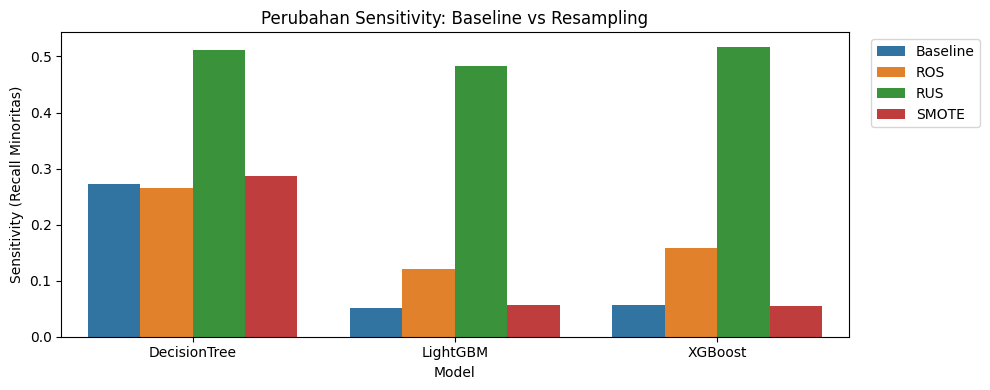

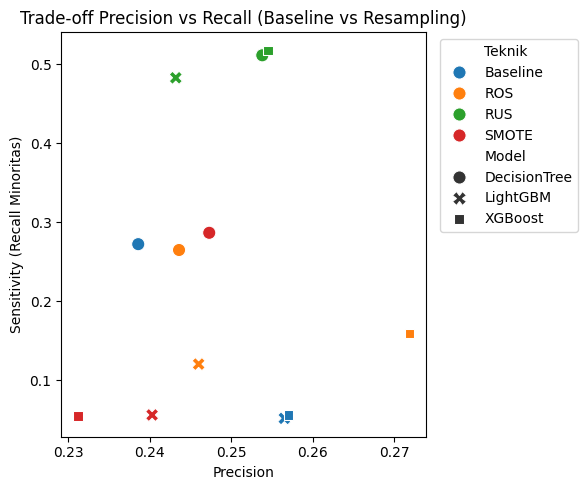


Analisis otomatis: teknik paling efektif per model
- DecisionTree: RUS memberi Sens tertinggi (0.5114)
- LightGBM: RUS memberi Sens tertinggi (0.4829)
- XGBoost: RUS memberi Sens tertinggi (0.5172)

Apakah boosting lebih stabil dari Decision Tree?
- Rata-rata std Sensitivity boosting: 0.0487
- Rata-rata std Sensitivity DecisionTree: 0.0593
  → Boosting lebih stabil dibanding Decision Tree.

Apakah semua model mengalami peningkatan sensitivity?
- DecisionTree: YES (baseline 0.2722 -> max resampling 0.5114)
- LightGBM: YES (baseline 0.0516 -> max resampling 0.4829)
- XGBoost: YES (baseline 0.0558 -> max resampling 0.5172)


In [17]:
# --- STEP 2.6: TABEL KOMPARASI BESAR ---
print("\n" + "="*60)
print("STEP 2.6: TABEL KOMPARASI BESAR (BASELINE + RESAMPLING)")
print("="*60)

# Siapkan tabel baseline dengan format yang sama
baseline_big = baseline_summary_df[[
    "Model",
    "AUC_mean", "Sensitivity_mean", "Specificity_mean",
    "Precision_mean", "F1-Score_mean",
]].copy()
baseline_big["Teknik"] = "Baseline"

# Siapkan tabel resampling
resampling_big = resampling_summary_df[[
    "Model", "Resampling",
    "AUC_mean", "Sensitivity_mean", "Specificity_mean",
    "Precision_mean", "F1-Score_mean",
]].copy()
resampling_big.rename(columns={"Resampling": "Teknik"}, inplace=True)

# Gabungkan dan rapikan
big_table = pd.concat([baseline_big, resampling_big], ignore_index=True)
big_table = big_table[[
    "Model", "Teknik", "AUC_mean", "Sensitivity_mean", "Specificity_mean", "Precision_mean", "F1-Score_mean",
]]
big_table.columns = ["Model", "Teknik", "AUC", "Sens", "Spec", "Prec", "F1"]
big_table = big_table.sort_values(by=["Model", "Teknik"]).reset_index(drop=True)

# Round angka
for col in ["AUC", "Sens", "Spec", "Prec", "F1"]:
    big_table[col] = big_table[col].round(4)

print("\nTabel Komparasi Besar:")
print(big_table.to_string(index=False))

# Simpan tabel
big_table.to_csv("baseline_vs_resampling.csv", index=False)
print("\nTabel tersimpan di: baseline_vs_resampling.csv")

# --- GRAFIK PERUBAHAN SENSITIVITY ---
plt.figure(figsize=(10, 4))
plot_sens = big_table.copy()
sns.barplot(data=plot_sens, x="Model", y="Sens", hue="Teknik")
plt.title("Perubahan Sensitivity: Baseline vs Resampling")
plt.ylabel("Sensitivity (Recall Minoritas)")
plt.xlabel("Model")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# --- ANALISIS TRADE-OFF PRECISION VS RECALL ---
plt.figure(figsize=(6, 5))
sns.scatterplot(data=big_table, x="Prec", y="Sens", hue="Teknik", style="Model", s=90)
plt.title("Trade-off Precision vs Recall (Baseline vs Resampling)")
plt.xlabel("Precision")
plt.ylabel("Sensitivity (Recall Minoritas)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# --- ANALISIS TEKS OTOMATIS ---
print("\nAnalisis otomatis: teknik paling efektif per model")
for model_name in big_table["Model"].unique():
    subset = big_table[big_table["Model"] == model_name].copy()
    best_row = subset.sort_values(by="Sens", ascending=False).iloc[0]
    print(f"- {model_name}: {best_row['Teknik']} memberi Sens tertinggi ({best_row['Sens']:.4f})")

print("\nApakah boosting lebih stabil dari Decision Tree?")
boosting = big_table[big_table["Model"].isin(["XGBoost", "LightGBM"])].copy()
dtree = big_table[big_table["Model"] == "DecisionTree"].copy()

if not boosting.empty and not dtree.empty:
    boost_std = resampling_summary_df[resampling_summary_df["Model"].isin(["XGBoost", "LightGBM"])]["Sensitivity_std"].mean()
    dt_std = resampling_summary_df[resampling_summary_df["Model"] == "DecisionTree"]["Sensitivity_std"].mean()
    print(f"- Rata-rata std Sensitivity boosting: {boost_std:.4f}")
    print(f"- Rata-rata std Sensitivity DecisionTree: {dt_std:.4f}")
    if boost_std < dt_std:
        print("  → Boosting lebih stabil dibanding Decision Tree.")
    else:
        print("  → Decision Tree sama/lebih stabil dibanding boosting.")

print("\nApakah semua model mengalami peningkatan sensitivity?")
for model_name in big_table["Model"].unique():
    base_sens = big_table[(big_table["Model"] == model_name) & (big_table["Teknik"] == "Baseline")]["Sens"].values
    res_max = big_table[(big_table["Model"] == model_name) & (big_table["Teknik"] != "Baseline")]["Sens"].max()
    if len(base_sens) > 0:
        if res_max > base_sens[0]:
            print(f"- {model_name}: YES (baseline {base_sens[0]:.4f} -> max resampling {res_max:.4f})")
        else:
            print(f"- {model_name}: NO (baseline {base_sens[0]:.4f} -> max resampling {res_max:.4f})")

## Output Akhir STEP Baseline

### Output yang Tersedia:

1. **Distribusi Kelas Dataset**
   - Tabel dan grafik di cell "EDA & Analisis Imbalance"
   - Imbalance Ratio (IR) sudah dihitung

2. **Hasil 10-Fold CV Semua Model** (Cell: Stratified 10-Fold CV + Training)
   - Hasil detail untuk setiap fold + model
   - Metrik per fold: Accuracy, Sensitivity, Specificity, Precision, F1, AUC

3. **Tabel Komparasi Baseline** (Cell: Agregasi Hasil)
   - Mean ± Std untuk semua metrik
   - Disimpan di `baseline_summary.csv`

4. **Visualisasi ROC Curve** (Cell: ROC Curve Baseline)
   - Perbandingan ROC curve antar model

5. **Analisis Bias Kelas Minoritas** (Cell: Analisis Hasil Baseline)
   - Checkpoint otomatis jika ada bias mayoritas
   - Interpretasi sensitivitas vs akurasi

### Penjelasan Hasil Baseline:

- Model dilatih **tanpa resampling, class weighting, atau threshold tuning**.
- Fokus evaluasi pada **Sensitivity (Recall kelas minoritas)** karena data imbalanced.
- Jika Sensitivity rendah meski Accuracy tinggi → **ada bias mayoritas**.
- Hasil ini menjadi **baseline untuk perbandingan** dengan metode imbalance learning di tahap berikutnya.

### Langkah Selanjutnya:

Setelah phase baseline ini selesai, akan dilanjut ke:  
- **STEP 2**: Teknik Resampling (SMOTE, ROS, dll)
- **STEP 3**: Class Weighting dan Cost-Sensitive Learning
- **STEP 4**: Threshold Tuning
- **STEP 5**: Ensemble & Advanced Techniques